Pandas and duckdb

#####  Task 0 Load the sakila_sqlite.duckdb into a duckdb database (with dlt tool från duckdb_pandas.py which is already run in command prompt ->  uv add "dlt[sql_database]" "dlt[parquet]" duckdb pandas ipykernel & then i also  ran uv run load_sakila_sqlite_duckdb.py )

In [ ]:
# Task 0 = load_sakila_sqlite.duckdb.py

import duckdb

with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC;").df()

description

In [ ]:
# Task 0 = load_sakila.sql


# import duckdb
# from pathlib import Path

# duckdb_path = "data/sakila.duckdb"
# Path(duckdb_path).unlink(missing_ok=True)

# with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
#     conn.sql(ingest_script.read())

#     description = conn.sql("DESC;").df()
#     films = conn.sql("FROM film;").df()

        

# films.head() 

In [ ]:
# description

### Task 1

###  Read all data into dictionary of pandas dataframes

In [ ]:
dfs = {}

with duckdb.connect("data/sakila.duckdb") as conn:
    for name in description["name"]:
        dfs[name] = conn.sql(f"FROM staging.{name};").df()
        duckdb.register(name, dfs[name])

dfs.keys()

In [ ]:
# task 1a)
#  Which movies are longer than 3 hours (180 minutes), show the title and its length?

length_of_movie=duckdb.sql("""    
    SELECT title, length AS movie_length
    FROM film
    WHERE length > 180;         
    """).df()

length_of_movie.head()

In [ ]:
# task 1b)
# Which movies have the word "love" in its title? Show the following columns :title, rating, length, description

love_word=duckdb.sql("""
SELECT title, rating, length, description
FROM film
WHERE title ILIKE '%love%';
""").df()

love_word.head()

In [ ]:
# task 1c)
# Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and longest movie length

length_statistik=duckdb.sql("""
SELECT
MIN(length) AS shortest,
MAX(length) AS longest,
AVG(length) AS average,
MEDIAN(length) AS median 
FROM film;                          
""").df()

length_statistik.head()



In [ ]:
# task 1d)
#  The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can  keep the movie. The Manager wants to know the 10 most expensive movies to rent per day

expensive_movies=duckdb.sql("""
SELECT title, rental_rate, rental_duration, (rental_rate / rental_duration) AS cost_per_day
FROM film
ORDER BY cost_per_day DESC
LIMIT 10;                              
""").df()

expensive_movies

In [ ]:
# task 1e)
# Which actors have played in most movies? Show the top 10 actors with the number of movies they have played in.

top_actors=duckdb.sql("""
SELECT a.actor_id, a.first_name, a.last_name, COUNT(*) AS film_count
FROM actor a
JOIN film_actor fa ON a.actor_id = fa.actor_id
GROUP BY a.actor_id, a.first_name, a.last_name
ORDER BY film_count DESC
LIMIT 10;                      
""").df()

top_actors

In [ ]:
duckdb.sql("""from actor""")

In [ ]:
duckdb.sql("""from film""")


In [ ]:
# task 1f.1) 
# How many actors are there in each film?



tot_actors=duckdb.sql(""" 
SELECT
    title,
    COUNT(DISTINCT a.actor_id) AS actor_count
    FROM film f
    JOIN film_actor fa ON f.film_id = fa.film_id
    JOIN actor a ON a.actor_id = fa.actor_id    
    GROUP BY title
    ORDER BY actor_count DESC
    LIMIT 10;
""").df()

tot_actors

In [ ]:
# task 1f.2) 
# Top 10 mest hyrda filmer?

most_hired_movies=duckdb.sql("""
SELECT
    f.title,
    COUNT(*) AS rental_count
FROM film f
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
GROUP BY f.title
ORDER BY rental_count DESC
LIMIT 10;
""").df()

most_hired_movies

In [ ]:
# Kochan hjälpte mig men vi hittade inga bra lösning
# task 1f.3) 
# Vilka filmer lämnas tillbaka senast? (Dvs. filmer med längst genomsnittlig retur-tid)

senaste_filmer= duckdb.sql("""
SELECT
    f.title,
    extract(day from AVG(r.return_date - r.rental_date)) AS avg_return_duration
FROM rental r
JOIN inventory i ON r.inventory_id = i.inventory_id
JOIN film f ON i.film_id = f.film_id
WHERE r.return_date IS NOT NULL
GROUP BY f.title
ORDER BY avg_return_duration DESC    
LIMIT 10;
""").df()

senaste_filmer

In [ ]:
# task 1f.4) 
# Vilken kategori har längst genomsnittlig filmlängd?

avg_filmlangd_kategori=duckdb.sql("""
SELECT
    catg.name AS category,
    AVG(f.length) AS avg_length
FROM category catg
JOIN film_category fc ON catg.category_id = fc.category_id
JOIN film f ON fc.film_id = f.film_id
GROUP BY catg.name
ORDER BY avg_length DESC
LIMIT 10;
""").df()

avg_filmlangd_kategori

### Task 2

In [ ]:
# task 2a)
#  Who are our top 5 customers by total spend? 
# The Manager wants to know so that they can reward them with special offers. 
# Create a bar chart showing the top 5 customers by total spend

topmost_5_clients = duckdb.sql(""" 
SELECT  c.customer_id,
        c.first_name || ' ' || c.last_name AS customer_name,
        SUM(p.amount) AS total_spend
FROM customer c
JOIN payment p ON c.customer_id = p.customer_id
GROUP BY c.customer_id, customer_name
ORDER BY total_spend DESC;
""").df()

topmost_5_clients.head()

In [ ]:
# task 2a) with the bar chart
#  a bar chart showing the top 5 customers by total spend.

ax = topmost_5_clients.head().plot(
    kind="barh",
    x="customer_name",
    y="total_spend",
    title="Topmost 5 clients by total spend",
    xlabel="Total amount spent",
    ylabel="Name of the client"    ,
)
ax.invert_yaxis()

In [ ]:
# task 2b)
# How much money does each film category bring in? 
# Make a bar chart showing total revenue per film category.

income_per_category = duckdb.sql(""" 
 SELECT c.name AS category,
        SUM(p.amount) AS total_income
FROM category c
JOIN film_category fc ON c.category_id = fc.category_id
JOIN film f ON fc.film_id = f.film_id
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
JOIN payment p ON r.rental_id = p.rental_id
GROUP BY c.name
ORDER BY total_income DESC;
""").df()

income_per_category

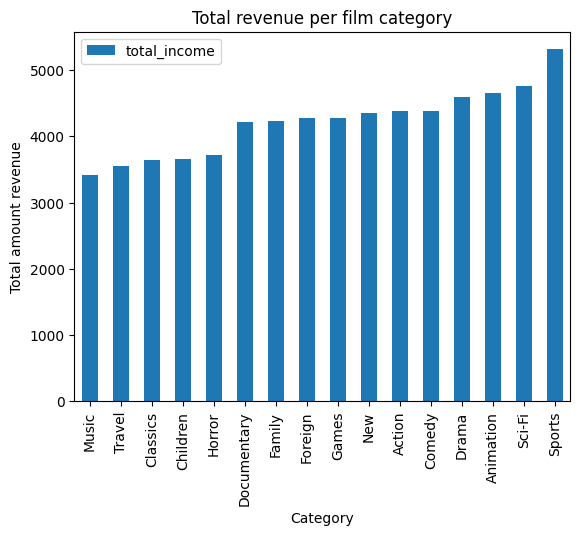

In [27]:
# task 2b) with the bar chart
#  a bar chart showing total revenue per film category

ax = income_per_category.plot(
    kind="bar",
    x="category",
    y="total_income",
    title="Total revenue per film category",
    xlabel="Category",
    ylabel="Total amount revenue"
)

ax.invert_xaxis()

### Task 3

In [ ]:
# task 3)
#  The Manager wants some of your findings from task 1 and 2 to be included in the  dashboard. 
# Make sure to combine relevant text, tables and graphs. 
# Also feel free to add more analysis and  graphs to the dashboard